# Chapter 5: Electromechanical Dynamics | Small Disturbances

#### A quick introduction the simulation of a small disturbance analysis 

Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

## Table of Contents

1. [Power System Dynamics](#power-system-dynamics)
    - [The Swing Equation](#the-swing-equation)
    - [Equilibrium Points](#equilibrium-points)
4. [System](#system)
    - [System Data Definitions](#system-data-definitions)
6. [Power-Angle Characteristic](#power-angle-characteristic)
    - [Stability Criterion of Power-Angle Characteristic](#stability-criterion)
8. [Linearized Small Signal Analysis](#linearized-small-signal-analysis)
    - [State-Space Representation](#state-space-representation)
    - [Stability Analysis using Eigenvalues](#stability-analysis-using-eigenvalues)
    - [Root-Locus, the Effect of Variables](#root-locus-the-effect-of-variables)
9. [Bode Plot Analysis](#bode-plot-analysis)
    - [Adding a Governor](#adding-a-governor)

Relevant Material from TET4180 Power System Stability and Control:
1. Slides (TET4180 Power System Stability and Control | Chapter 5: Electromechanical Dynamics – Small disturbances)
2. Power System Dynamics, Machowski   (Ch. 5.1: Swing equation | Ch. 5.3: Equilibrium points (synchronising power/torque) | Ch. 5.4: Steady state stability (Linear analysis) | Ch. 5.2: Damping power (torque) | Ch. 4.2.4.4: Rotor flux dynamics)
3. Assignment 4: Electromechanical dynamics - small disturbances


Code implemented by; Varg Førland. Date; 31.01.2025

Last update; 11.02.2025

GitHub Copilot used for assistance in coding.

In [17]:
#%pip install git+https://github.com/hallvar-h/tops

import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import numpy as np
from notebook_utils import getPhasorsDictionary_SmallDist
from IPython.display import display, Math
import control as ctrl

# Control package documentation
"""https://python-control.readthedocs.io/en/0.10.0/"""

# Example used for control package:
"""https://jckantor.github.io/CBE30338/05.03-Creating-Bode-Plots.html"""
# requires coefficients of the numerator and denominator polynomials
# the coefficients are given starting with the highest power of
#from tops.ps_models import ieee39

'https://jckantor.github.io/CBE30338/05.03-Creating-Bode-Plots.html'

# Power System Dynamics

To effectively analyze the Power System it needs to be modeled, which is a balance act between retaining information while simplifying a complex system. First, we look at the swing equation and the relation between electrical and mechanical energy.

---

## The swing equation (chap. 5.1)

The **swing equation** is a fundamental equation in power systems that describes the dynamics of a synchronous machine's rotor. It represents the balance between the mechanical and electrical torques and how they affect the machine's angular position and speed.

- **Classic swing equation:**
    $$ J \frac{d^2\delta}{dt^2} + D_d \frac{d\delta}{dt} = \tau_m - \tau_e $$
    Where:
    - $ J $: Total moment of inertia
    - $ D_d $: Damping coefficient
    - $ \tau_m $: Mechanical torque
    - $ \tau_e $: Electromechanical torque
    - $ \delta $: Angle

This equation is derived from Newtons second law of motion as can be seen in the lecture slides. A particulary important relation which is utlized is the relation between rotational speed, or frequency, and the angle. The rotational speed can be expressed as 
$$
\omega_m = \omega_{sm} + \Delta \omega_m = \omega_{sm} + \frac{d\delta}{dt}
$$
where $\omega_sm$ is the synchronous speed, i.e. a constant $2 \pi \cdot 50Hz$. This also gives the relation 
$$
\frac{d\omega_m}{dt} = \frac{d^2\delta}{dt^2}
$$

#### Alternative expressions

The swing equation is commonly expressed in p.u. using power rather than torque, and inertia expressed in seconds. This version of the swing equation is expressed as

$$ 2 H \frac{d^2\delta}{dt^2} = P_m - P_e (\delta) - D_d \frac{d\delta}{dt} $$

---

## Equilibrium points (synchronising power/torque) (chap. 5.3)
Section 5.1 shows that the accelerating power depends on the difference between turbine power $P_m$ and electrical air-gap power $P_e$ (minus damping power $P_D$). Mechanical power is controlled by the turbine governor, while electrical air-gap power depends on generator loading, parameters, and power angle. In this section, we consider only the steady-state model of the generator-infinite busbar system, with the infinite busbar voltage $V_s$ as the reference.

In steady state, the generator is represented by a constant emf $E_q$ behind synchronous reactances $X_d$ and $X_q$. Neglecting resistances and shunt admittances, the air-gap power $P_e$ equals the power delivered to the system $P_s$ and is given by :
$$
P_e = P_{Eq} = \frac{E_q V_s}{x_d} \sin \delta + \frac{V_s^2}{2} (\frac{1}{x_q} - \frac{1}{x_d})  sin(2 \delta)
$$
in a salient pole generator. $x_d = X_d + X$, $x_q = X_q + X$, and $X = X_T + X_s$ is the combined reactance of the step-up transformer and equivalent network. The angle $\delta$ is the angle between $E_q$ and $V_s$ phasors (power angle) and the spatial angle between the generator rotor and the fictitious system generator (rotor angle). This links the swing equation with the electrical state of the generator. For constant $E_q$ and $V_s$, the power-angle characteristic $P_e = P_e(\delta)$ allows rewriting the swing equation.

If we have power with symmetry, for example in a round rotor generator where $x_d =x_q$, the expression simplifies to 
$$
P_e = P_{Eq} = \frac{E_q V_s}{x_d} \sin \delta
$$

Using these equations we can now consider the relationship between the power and power angle.

Similarly we can look at the transient power-angle characteristic, formulated as 
$$
P_e' = P_{Eq}' = \frac{E_q' V_s}{x_d'} \sin \delta' + \frac{V_s^2}{2} (\frac{1}{x_q} - \frac{1}{x_d'})  sin(2 \delta')
$$

We continue with the same system as previously.


## System
A power plant is connected to an infinite grid as shown in the figure below and delivers 80 MW active power and 20 Mvar reactive power to grid. The power plant has a salient-pole generator, and the relevant parameters for the generator, transformer and transmission line are given in the table below:

![Figure1](Figures/System_Notebooks.png)

| **Category**               | **Parameter** | **Value**  | **Comment**                                                                 |
|----------------------------|---------------|------------|-----------------------------------------------------------------------------|
|                            |     | |                                                                             |
| **Generator Parameters**                          |
|   | $H$           | 5.0 seconds |                                                                             |
|                            | $D$           | 10.0 p.u.  | All per unit values are referred to $V_{\text{base}} = 132 \, \text{kV}$ and $S_{\text{base}} = 100 \, \text{MW}$ |
|                            | $X_q$         | 0.8 p.u.   |                                                                             |
|                            | $X_d$         | 1.0 p.u.   |                                                                             |
|                            | $X_d'$        | 0.3 p.u.   |                                                                             |
|                            | $T_{d0}'$     | 7.0 seconds |                                                                             |
|                            |  
|   **Transformer**                                                             |
|  | $X_t$         | 0.1 p.u.   | Nominal voltages: 17/132 kV, referred to $S_{\text{base}} = 100 \, \text{MW}$ |
|                            |  
|  **Transmission Line**                               |     | |                                                                             |
|  | $X_l$         | 0.1 p.u.   | Referred to $V_{\text{base}} = 132 \, \text{kV}$ and $S_{\text{base}} = 100 \, \text{MW}$ |
|                            |     | |                                                                             |



In [18]:
# System data Definitions:
# Base data
Sb = 100 # MVA
Vb_lv = 10 # kV
Vb_hv = 132 # kV
# pu conversion
Vs_kV = 132 + 0j # kV < deg
Vs = Vs_kV / Vb_hv # pu
P_MW = 80 # MW delivered power to network 
Q_MVAR = 20 #MVAR delivered power to network
P = P_MW / Sb # pu
Q = Q_MVAR / Sb # pu

#Transformer data
Xt =  0.1 # pu

#Generator data
H = 5 # s
D = 10 # pu
Xq = 0.8 # pu
Xd = 1.0 # pu
Xd_t = 0.3 # pu (_t means transient) (_st means subtransient)
Td0_t = 7.0 # s

#Line data
Xl = 0.1 # pu

xq = Xq + Xt + Xl
xd = Xd + Xt + Xl
xd_t = Xd_t + Xt + Xl

# Function which calculates the phasors for the generator model - Same as in notebook 2
phasors = getPhasorsDictionary_SmallDist(
    P=P, 
    Q=Q, 
    Vs=Vs, 
    Xq=Xq, 
    Xd=Xd, 
    Xd_t=Xd_t, 
    Xt=Xt, 
    Xl=Xl
)

Eq = phasors['Eq']
Eq_t = phasors['Eq_t']
delta = np.angle(Eq)

print("From calculation / previous notebooks:")
display(Math(r'E_q = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Eq), np.angle(Eq)*180/np.pi)))
display(Math(r'E_q^t = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Eq_t), np.angle(Eq_t)*180/np.pi)))
display(Math(r'\delta = {0:.2f}^\circ'.format(delta*180/np.pi)))


From calculation / previous notebooks:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

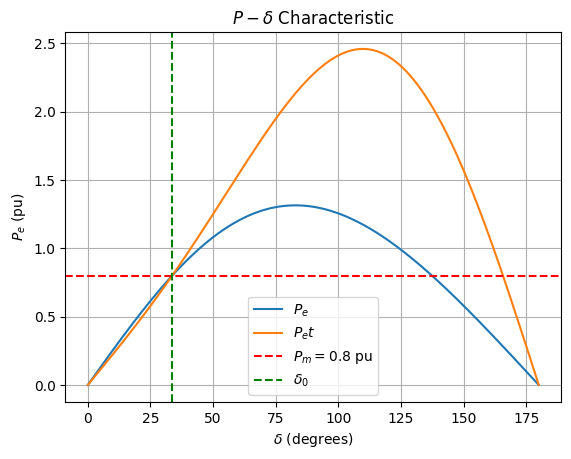

In [19]:
P_m = 0.8  # Mechanical power in pu

E_q_mag = abs(Eq)  # Constant emf behind synchronous reactance
E_q_mag_t = abs(Eq_t)  # Constant emf behind transient reactance
Vs_mag = abs(Vs)  # Magnitude of the stator voltage

# Delta values from 0 to pi
delta = np.linspace(0, np.pi, 1000)
delta_deg = np.degrees(delta)

# Power-angle characteristic
P_e = (E_q_mag * Vs_mag / xd) * np.sin(delta) + Vs_mag ** 2 / 2 * (1/xq - 1/xd) * np.sin(2 * delta)
P_et = (E_q_mag_t * Vs_mag / xd_t) * np.sin(delta) + Vs_mag ** 2 / 2 * (1/xq - 1/xd_t) * np.sin(2 * delta)

# Plotting
delta_0 = np.degrees(np.angle(Eq))  # Calculate delta_0 in degrees

plt.figure()
plt.plot(delta_deg, P_e, label='$P_e$')
plt.plot(delta_deg, P_et, label='$P_et$')
plt.xlabel(r'$\delta$ (degrees)')
plt.ylabel(r'$P_e$ (pu)')
plt.title(r'$P-\delta$ Characteristic')
plt.grid(True)
plt.axhline(y=P_m, color='r', linestyle='--', label=r'$P_m = 0.8$ pu')
plt.axvline(x=delta_0, color='g', linestyle='--', label=r'$\delta_0$')
plt.legend()
plt.show()

## Stability criterion $K_E$ and $K_E'$  

One way to assess the small signal stability of the system is the $K_E$ criterion. This is done by linearizing and assessing the rate of change in the operating point. We formulate this as
$$K_E = \left.\frac{\partial P_E}{\partial \delta} \right \vert_{\delta = \delta_0}  > 0 $$
or for the transient power-angle characteristic as
$$K_{E'} = \left.\frac{\partial P_{E'}}{\partial \delta'} \right \vert_{\delta' = \delta_0} > 0 $$
This means that the change in power at the operating point must be positive for the system to be stable.


Solving the partial derivations we get the expression
$$\frac{\partial P_E}{\partial \delta} = \frac{E_q V_s}{x_d} \cos \delta + V_s^2 (\frac{1}{x_q} - \frac{1}{x_d})  \cos (2 \delta) $$

and inserting for $\delta = \delta_0$ to get $K_E$
$$
K_E = \frac{E_q V_s}{x_d} \cos \delta_0 + V_s^2 (\frac{1}{x_q} - \frac{1}{x_d})  \cos (2 \delta_0)
$$

The same goes for the transient characteristic. Now lets look if our system upholds this criterion. Is the system stable? Can you change the values and see if it will still be stable?

In [20]:
# Calculate K_E and K_E'
delta_0_rad = np.angle(Eq)  # delta_0 in radians

# Calculate K_E
K_E = (E_q_mag * Vs_mag / xd) * np.cos(delta_0_rad) + Vs_mag ** 2 * (1/xq - 1/xd) * np.cos(2 * delta_0_rad)

# Calculate K_E'
K_E_t = (E_q_mag_t * Vs_mag / xd_t) * np.cos(delta_0_rad) + Vs_mag ** 2 * (1/xq - 1/xd_t) * np.cos(2 * delta_0_rad)


print(" Expressions for K_E and K_E' are:")
display(Math(rf'K_E = {round(E_q_mag * Vs_mag / xd, 3)} \cos(\delta_0)  + {round(Vs_mag ** 2 * (1/xq - 1/xd), 3)} \cos(2\delta_0)'))
display(Math(rf'K_E^t = {round(E_q_mag_t * Vs_mag / xd_t, 3)} \cos(\delta_0) + {round(Vs_mag ** 2 * (1/xq - 1/xd_t), 3)} \cos(2\delta_0)'))

print(f"Stability criterion values with initial angle {round(delta_0,3)} degs:")
display(Math(r'K_E = {0:.4f}'.format(K_E)))
display(Math(r'K_E^t = {0:.4f}'.format(K_E_t)))

 Expressions for K_E and K_E' are:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Stability criterion values with initial angle 33.69 degs:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Linearized small signal analysis

There are a lot of tools for linear analysis of stability, we will look at stability criterion of the P-$\delta$ characteristic, modal (eigenvalue) analysis and frequency response (bode). The system has a linearized model which can be seen represented in the laplace domain in the figure below

<img src="Figures/Linearized_Plant_Model.png" width="550">

## Linearised Swing Equation from the Block Diagram
Now lets see how this linear block diagram can be recognized in the swing equation. For this analysis, we neglect the impact of the voltage regulator and rotor flux dynamics, meaning we assume that $D_\delta = 0$ and we do not look at the voltage part of the loop (as they are decoupled). Now lets set up our linearized model for analysis.

### Extracting Equations from the Block Diagram
From the block diagram, we can derive the following equations:

$$ \delta' = \frac{2\pi f_N}{s} \Delta\omega $$

$$ \Delta\omega = \frac{1}{2Hs} (P_m - D\Delta\omega - K_E' \delta' - D_s\Delta E_q') $$

Since $D_s = 0$, the equation simplifies to:

$$ \Delta\omega = \frac{1}{2Hs} P_m - \frac{D}{2H} \Delta\omega - \frac{K_E'}{2H} \delta' $$

Applying Laplace transformation ($s \rightarrow \frac{d}{dt}$ in time domain), we get:

$$ \dot{\delta} = 2\pi f_N \Delta\omega $$

$$ \Delta \dot{\omega} = - \frac{K_E'}{2H} \delta' - \frac{D}{2H} \Delta\omega + \frac{1}{2H} P_m $$

Now lets define our variables for this example


In [21]:
# Constants
# H, Td0' D already defined
f_N = 50  # Hz Nominal frequency
w_N = 2 * np.pi * f_N  # Nominal angular frequency

# Display constants
display(Math(r'H = {0:.1f} \, \text{{s}}'.format(H)))
display(Math(r'D = {0:.1f} \, \text{{p.u.}}'.format(D)))
display(Math(r'T_{{d0}}^{{t}} = {0:.1f} \, \text{{s}}'.format(Td0_t)))
display(Math(r'f_N = {0:.1f} \, \text{{Hz}}'.format(f_N)))
display(Math(r'\omega_N = {0:.1f} \, \text{{rad/s}}'.format(w_N)))
display(Math(r'K_E^{{\prime}} = {0:.4f}'.format(K_E_t)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### State-Space Representation
Defining the state and control vector:

$$ x = \begin{bmatrix} \delta \\ \Delta\omega \end{bmatrix}, \quad u = P_m $$

We can express the system in state-space form:

$$ \dot{x} = A x + B u $$

where:

$$ A = \begin{bmatrix} 0 & 2\pi f_N \\ -\frac{K_E'}{2H} & -\frac{D}{2H} \end{bmatrix}, \quad B = \begin{bmatrix} 0 \\ \frac{1}{2H} \end{bmatrix} $$

In [22]:
# Define the matrices A and B
A = np.array([[0, 2 * np.pi * f_N],
              [-K_E_t / (2 * H), -D / (2 * H)]])

B = np.array([[0],
              [1 / (2 * H)]])

# Display matrices A and B

print("Matrix A:")
print(np.round(A, 2))

print("\nMatrix B:")
print(np.round(B, 2))


Matrix A:
[[ 0.0000e+00  3.1416e+02]
 [-1.5000e-01 -1.0000e+00]]

Matrix B:
[[0. ]
 [0.1]]


### Stability Analysis using Eigenvalues
Using the state-space representation, we can now assess the stability by looking at the eigenvalues, or modes, of the system. We find the eigenvalues through:

$$ |\lambda I - A| = 0 $$

solved as

$$ \lambda = \frac{-D}{4H} \pm \sqrt{\left( \frac{D}{4H} \right)^2 - \frac{\pi f_N K_E'}{H} } $$

The system stability depends on the real part of $\lambda$. If the real part is negative, the system is stable; otherwise, it is unstable. We can express the eigenvalues by frequency and damping ratio through 
$$
f = \frac{\text{Imag}(\lambda)}{2\pi}
$$

$$
\zeta = -\frac{\text{Real}(\lambda)}{|\lambda|}
$$

The system is stable if the real part of all eigenvalues is negative. The frequency indicates the oscillation rate, and the damping ratio indicates how quickly the oscillations decay.

In [23]:
# Calculate eigenvalues
eigenvalues = np.linalg.eigvals(A)

# Print eigenvalues nicely
print("Eigenvalues of matrix A:")
for idx, eigenvalue in enumerate(eigenvalues, start=1):
    display(Math(rf'\lambda_{idx} = {eigenvalue:.4f}'))

# Calculate frequency in Hz and damping ratio
damping_ratio = -eigenvalues.real / np.abs(eigenvalues)
frequency_hz = (eigenvalues.imag) / (2 * np.pi)

# Print frequency and damping ratio
print("Frequency and Damping Ratio:")
for idx, (freq, damp) in enumerate(zip(frequency_hz, damping_ratio), start=1):
    display(Math(rf'f_{{{idx}}} = {freq:.4f} \, \text{{Hz}}, \, \zeta_{{{idx}}} = {damp:.4%} '))



Eigenvalues of matrix A:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Frequency and Damping Ratio:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Root-Locus, the Effect of Variables

An effective way to assess the stability of a power system is by examining the eigenvalues of the system's state-space representation. The root-locus method provides a graphical representation of how the eigenvalues (or poles) of a system change with variations in a particular parameter. This method is particularly useful for understanding the impact of different variables on system stability.

Now lets see how different variables affect the system stability. How does the different variables affect the eigenvalues? 

In our case, there are only two modes. However, for larger systems, we must examine relevant modes. Electromechanical modes are defined as eigenvalues with damping below 10% and frequency in the range of 0.1-2.0 Hz. These modes are analyzed because they are associated with the stability of the system. 

1. Are our modes electromechanical?
2. Which parameters have the biggest effect on the eigenvalues?
3. Does the parameters effect damping or frequency?

In [24]:
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
from notebook_utils import calculate_eigenvalues, plot_root_locus


# Create sliders for the variables
H_slider = FloatSlider(value=H, min=0.1, max=10.0, step=0.01, description='H')
D_slider = FloatSlider(value=D, min=0.1, max=20.0, step=0.01, description='D')
K_E_t_slider = FloatSlider(value=K_E_t, min=0.1, max=3.0, step=0.01, description='K_E_t')
f_N_slider = FloatSlider(value=f_N, min=10, max=60, step=1, description='f_N')

# Create the interactive plot
interact(plot_root_locus, H=H_slider, D=D_slider, K_E_t=K_E_t_slider, f_N=f_N_slider, continuous_update=False)

interactive(children=(FloatSlider(value=5.0, description='H', max=10.0, min=0.1, step=0.01), FloatSlider(value…

<function notebook_utils.plot_root_locus(H, D, K_E_t, f_N)>

# Bode Plot Analysis - Frequency Response

Bode plots are a fundamental tool in control and power system analysis used to assess the frequency response of a linear system. In the context of small-signal stability, they help visualize how the system responds to disturbances at different frequencies. The magnitude plot shows the system gain across frequencies, while the phase plot reveals phase shifts that indicate potential instability. By analyzing the gain and phase margins, we can determine how robust the system is to perturbations and how close it is to instability. This makes Bode plots particularly useful in evaluating the dynamic behavior of power system components and controllers.

From the block diagram or the swing equation, we find the transfer function for the generator:

$$\Delta\omega(s) = \frac{1}{2Hs} \left( P_m - K_E' \frac{2\pi f_N}{s} \Delta\omega - D \Delta\omega \right)$$

Rearranging:

$$2Hs^2 \Delta\omega(s) + Ds\Delta\omega + 2\pi f_N K_E' \Delta\omega = s P_m$$

Solving for $\Delta\omega(s)$:

$$\Delta\omega(s) = \frac{s}{2Hs^2 + Ds + 2\pi f_N K_E'} P_m$$

We now plot the frequency response in a Bode Plot. 
1. Is the system stable?
1. What are the gain and phase margins?


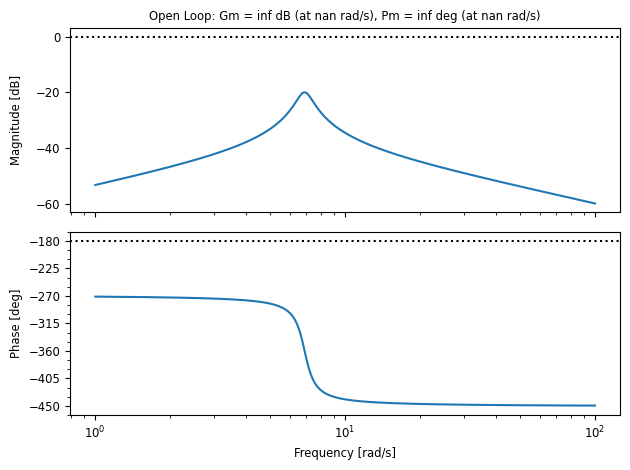

In [25]:
H_OL = ctrl.TransferFunction([1, 0], [2*H, D, w_N*K_E_t], name='Open Loop')

# Bode plot
plt.figure()
ctrl.bode_plot(H_OL, dB=True, display_margins=True)
plt.show()

## Adding a Governor 
We now want to add a governor block in our system. The block consists of a Governor gain $K_{gov}$ and a filter with the time constant $T_w$, with a transferfunction of 
$$
H_{GOV} = K_{gov} \cdot \frac{1-T_w s}{1 + 0.5 T_w s}
$$
and our new open loop transfer function becomes
$$
H_{OL,gov} = K_{gov} \cdot \frac{1-T_w s}{1 + 0.5 T_w s} \cdot \frac{s}{2Hs^2 + Ds + 2\pi f_N K_E'}
$$

Usual values are:
- $K_{gov} = 25$
- $T_{w} = 1$

1. Is the system stable now? 
2. How can we tune the controller to have a sufficient gain and phase margin?
3. Can you add our block in the eigenvalue calculations and see how it effects the system?


In [26]:
from ipywidgets import fixed
from notebook_utils import update_plots_small_signal



# Create sliders for Tw and Kgov
Tw_slider = FloatSlider(value=1, min=0.05, max=10.0, step=0.05, description='Tw')
Kgov_slider = FloatSlider(value=25, min=0.1, max=100, step=0.1, description='Kgov')

# Interactive plot
interact(update_plots_small_signal, Tw=Tw_slider, Kgov=Kgov_slider, H=fixed(H), D=fixed(D), w_N=fixed(w_N), K_E_t=fixed(K_E_t), continuous_update=False)


interactive(children=(FloatSlider(value=1.0, description='Tw', max=10.0, min=0.05, step=0.05), FloatSlider(val…

<function notebook_utils.update_plots_small_signal(Tw, Kgov, H, D, w_N, K_E_t)>